In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, ConvLSTM2D, MultiHeadAttention, Flatten, MaxPooling3D
from tensorflow.keras.callbacks import EarlyStopping

import os
import random
from pathlib import Path

In [ ]:
DIR = "D:/Kuliah/Deep_learning/Projek/UCF_CRIME/Dataset_npy"

In [ ]:
# cek
os.listdir(DIR)

['train', 'val']

In [ ]:
print("file train/fight: ",len(os.listdir(DIR+"/train/Fight")))
print("file train/nonfight:", len(os.listdir(DIR+"/train/NonFight")))
print("file val/fight: ", len(os.listdir(DIR+"/val/Fight")))
print("file val/nonfight: ", len(os.listdir(DIR+"/val/NonFight")))

file train/fight:  780
file train/nonfight: 647
file val/fight:  170
file val/nonfight:  150


In [ ]:
class FrameGenerator:
    def __init__(self, path, training=False):
        """ Returns a set of frames with their associated label.
          Args:
            path: Video file paths.
            n_frames: Number of frames.
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path

        self.training = training
        self.class_names = ['NonFight', 'Fight']
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):

        video_paths = list(self.path.glob('*/*.npy'))

        classes = [p.parent.name for p in video_paths]

        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = self.read_npy_file(path)
            label = self.class_ids_for_name[name]
            yield video_frames, label


    def read_npy_file(self, path):
        data = np.load(path)
        data = np.float32(data)
        data = data/255.0
        return data

In [ ]:
train_file = Path(DIR).joinpath("train").with_suffix('')
test_file = Path(DIR).joinpath("val").with_suffix('')
train_file

WindowsPath('D:/Kuliah/Deep_learning/Projek/UCF_CRIME/Dataset_npy/train')

In [ ]:
fg = FrameGenerator(train_file, training=True)

# test
frames, label = next(fg())
print(fg)
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (21, 224, 224, 3)
Label: 0


In [ ]:
# buat tf.data.Dataset
batch_size = 8

output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_file, training=True),
                                          output_signature=output_signature)


test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_file),
                                          output_signature=output_signature)


In [ ]:
train_ds = train_ds.batch(batch_size).shuffle(1000)
test_ds = test_ds.batch(batch_size).shuffle(1000)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
# test data
for frames, labels in train_ds.take(10):
    print(labels)

print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

tf.Tensor([0 1 1 1 1 0 1 0], shape=(8,), dtype=int16)
tf.Tensor([0 0 0 1 1 1 1 0], shape=(8,), dtype=int16)
tf.Tensor([1 0 1 0 1 1 0 1], shape=(8,), dtype=int16)
tf.Tensor([0 1 0 1 1 1 1 1], shape=(8,), dtype=int16)
tf.Tensor([1 0 0 0 1 1 1 1], shape=(8,), dtype=int16)
tf.Tensor([0 1 1 1 0 1 1 1], shape=(8,), dtype=int16)
tf.Tensor([0 1 1 0 1 1 1 0], shape=(8,), dtype=int16)
tf.Tensor([0 1 1 0 1 1 1 1], shape=(8,), dtype=int16)
tf.Tensor([0 0 0 1 0 0 1 0], shape=(8,), dtype=int16)
tf.Tensor([1 1 1 1 0 0 1 0], shape=(8,), dtype=int16)
Shape: (8, 21, 224, 224, 3)
Label: (8,)


In [ ]:
# RESNET pretrained
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  pooling='avg',
                                                  weights='imagenet')

In [ ]:
# buang avg pool layer
gap_layer_name = 'avg_pool'
gap_layer_index = None

for i, layer in enumerate(pretrained_model.layers):
    if layer.name == gap_layer_name:
        gap_layer_index = i
        break


if gap_layer_index is not None:
    model_without_gap = tf.keras.Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[gap_layer_index - 1].output)

else:
    print("GAP layer not found.")

In [ ]:
video_input_shape = (21, 224, 224, 3)

video_input = tf.keras.Input(shape=video_input_shape)
time_distributed = TimeDistributed(model_without_gap)(video_input)

conv_lstm_output = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(time_distributed)

mhsa_output = MultiHeadAttention(num_heads=8, key_dim=256, value_dim=256)(conv_lstm_output, conv_lstm_output)
# attention_time = TimeDistributed(tf.keras.layers.Lambda(lambda x: x))(mhsa_output)

conv_lstm_output2 = ConvLSTM2D(filters=256, kernel_size=(3, 3), padding="same", return_sequences=True)(mhsa_output)

maxpool3d = MaxPooling3D(pool_size=(1,2,2))(conv_lstm_output2)

flattened = Flatten()(maxpool3d)

dense_1 = Dense(1000, activation="relu")(flattened)
dense_2 = Dense(256, activation="relu")(dense_1)
dense_3 = Dense(10, activation="relu")(dense_2)
dense_4 = Dense(2, activation="softmax")(dense_3)

# Create the model
model = tf.keras.Model(inputs=video_input, outputs=dense_4)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 21, 224, 224, 3)]    0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 21, 7, 7, 2048)       2358771   ['input_2[0][0]']             
 ributed)                                                 2                                       
                                                                                                  
 conv_lstm2d (ConvLSTM2D)    (None, 21, 7, 7, 256)        2123468   ['time_distributed[0][0]']    
                                                          8                                       
                                                                                            

In [ ]:
epochs = 5
lr = 1e-5

In [ ]:
from tensorflow.keras.metrics import AUC

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr),
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
checkpoint_filepath = 'model_checkpoint_ucf_crime.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # Set to True if you only want to save weights
    save_freq='epoch',
    period=5  # Save every 5 epochs
)


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1, callbacks=[early_stopping,model_checkpoint_callback])

Epoch 1/5
179/179 [==============================] - 3142s 17s/step - loss: 0.5165 - accuracy: 0.7386 - val_loss: 0.7502 - val_accuracy: 0.5344
Epoch 2/5
179/179 [==============================] - 3077s 17s/step - loss: 0.2467 - accuracy: 0.9068 - val_loss: 0.7490 - val_accuracy: 0.6625
Epoch 3/5
179/179 [==============================] - 3065s 17s/step - loss: 0.0629 - accuracy: 0.9797 - val_loss: 0.8744 - val_accuracy: 0.8188
Epoch 4/5
179/179 [==============================] - 3067s 17s/step - loss: 0.0227 - accuracy: 0.9951 - val_loss: 0.8047 - val_accuracy: 0.8406
Epoch 5/5
179/179 [==============================] - 3064s 17s/step - loss: 0.0048 - accuracy: 0.9986 - val_loss: 1.0296 - val_accuracy: 0.8375


In [ ]:
model.evaluate(test_ds, return_dict=True)

40/40 [==============================] - 154s 4s/step - loss: 1.0296 - accuracy: 0.8375


{'loss': 1.029628038406372, 'accuracy': 0.8374999761581421}

In [ ]:
model.save('D:/Kuliah/Deep_learning/Projek/my_model_UCFC.tf')

INFO:tensorflow:Assets written to: D:/Kuliah/Deep_learning/Projek/my_model_UCFC.tf\assets


INFO:tensorflow:Assets written to: D:/Kuliah/Deep_learning/Projek/my_model_UCFC.tf\assets


In [ ]:

def plot_history(history):
    # Plot training & validation accuracy, loss, and AUC values
    plt.figure(figsize=(21, 5))  # Adjust the figsize to accommodate more plots

    # Plot training & validation accuracy values
    plt.subplot(1, 3, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 3, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


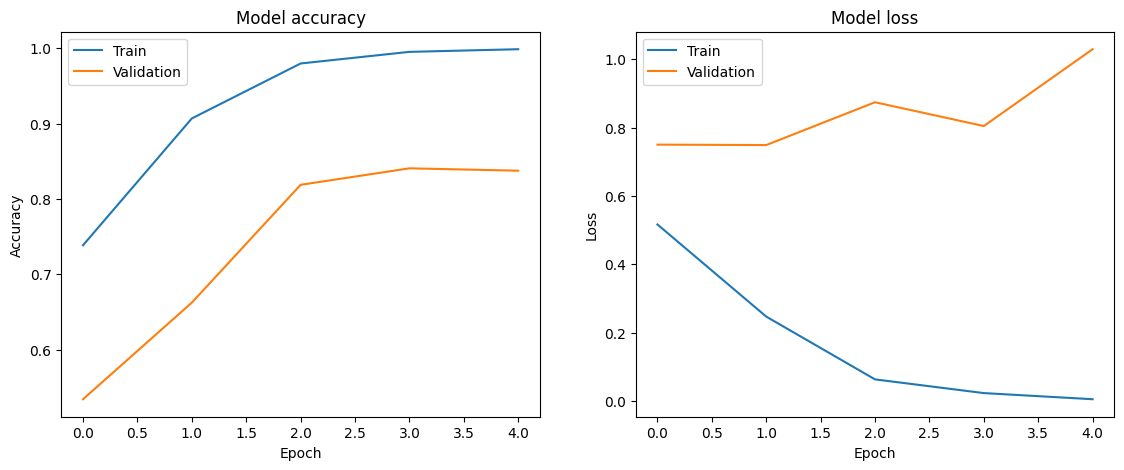

In [ ]:
plot_history(results.history)